# **Natural Language Processing with Disaster Tweets using Long Short-term Memory Networks**

####Kate Pendavinji

**Repository link:** [Project Repo](https://github.com/kape6379/ML5632_Final.git)

This mini-project aims to utilize natural language processing  to automate text based disaster detection based on tweets. The tweets were retrieved from [kaggle](https://www.kaggle.com/c/nlp-getting-started/overview) which sourced them from [here](https://www.appen.com/data-for-everyone). The goal is to binarily classify disasters as real or not based on context from the text derived from natural language processing (NLP).

Natural language processing will be used to preprocess the text from our training data. We will perform actions such as removing stop words, normalizing the text, removing punctuation, and tokenizing the text. The NLP process also includes feature extraction which we will play around with.

Then this project will use long short-term memory recurrent neural networks to train and test the given data. This will provide a predictive model that achieves the goal of automating the classification of tweets about disasters while improving accuracy and reliability.

_Please continue below for a brief overlook of_  **data size** _and_ **data structure**.
# Point Counter: 95/125

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import scipy as sp
import scipy.stats as stats
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import string
from collections import Counter
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from gensim.models import Word2Vec

In [5]:
train_file = '/content/drive/My Drive/NLP/train.csv'
test_file = '/content/drive/My Drive/NLP/test.csv'
train = pd.read_csv(train_file)
test = pd.read_csv(test_file)
print("Training Data Head \n\n", train.head(), "\n")
print("Testing Data Head \n\n", test.head(),"\n")
print("\n", train.shape)
print("\n", test.shape)

Training Data Head 

    id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  
0       1  
1       1  
2       1  
3       1  
4       1   

Testing Data Head 

    id keyword location                                               text
0   0     NaN      NaN                 Just happened a terrible car crash
1   2     NaN      NaN  Heard about #earthquake is different cities, s...
2   3     NaN      NaN  there is a forest fire at spot pond, geese are...
3   9     NaN      NaN           Apocalypse lighting. #Spokane #wildfires
4  11     NaN      NaN      Typhoon Soudelor kills

### Brief Overview of our Data:
As we can see from the first few rows of our testing and training data, our training data has columns such as **id, keyword, location, text, and target** and our testing data has the same columns minus target (as this column pertains to labels used for training).

From the shapes of these datasets we can see the dimensions: training data has **5 columns x 7,613 rows**, and the testing data has **4 columns x 3,263 rows**. This is the size and quantity of data points we will be looking at.

## Exploratory Data Analysis:

In this section we will perform our exploratory data analysis to get a better understanding of our data. This is also where we will be applying most NLP concepts listed in the introduction.

Below I've read in the kaggle data and created a histogram of the word count in all of the tweets from it. This is just to get an idea of how our data is distibuted lenght wise.

Beside that Is a box plot of tweet lengths based on it being labeled a real disaster or not. You'll notice that real disasters all sit around the same length at 100-120 words whereas the fake disasters have a more dispersed distribution of text lengths a lot of which are shorter than the real instances.

Next we will take a look at how to clean this data up and normalize it.

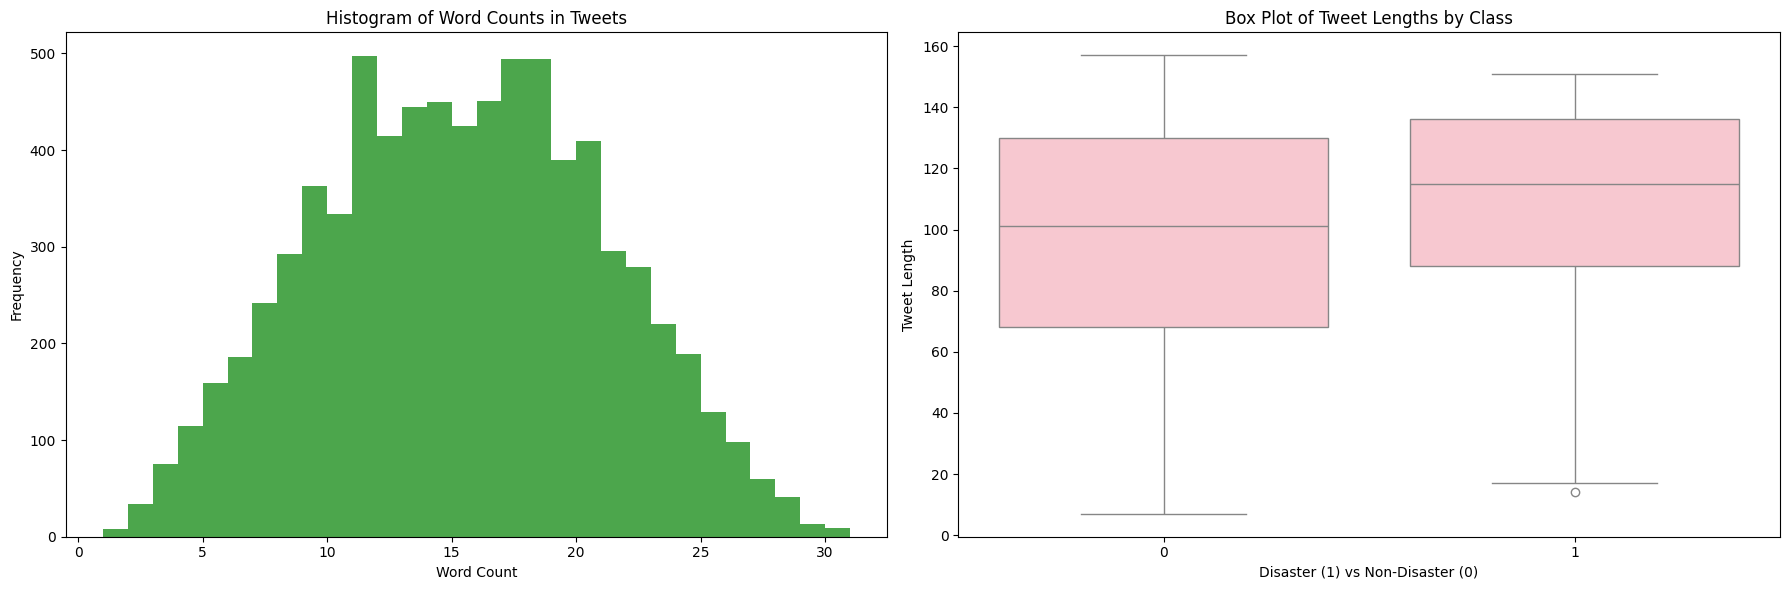

In [6]:
train_file = '/content/drive/My Drive/NLP/train.csv'
train = pd.read_csv(train_file)

train['tweet_length'] = train['text'].apply(len)
train['word_count'] = train['text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(18, 6))

plt.subplot(1, 2, 1)
plt.hist(train['word_count'], bins=30, color='green', alpha=0.7)
plt.title('Histogram of Word Counts in Tweets')
plt.xlabel('Word Count')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.boxplot(x='target', y='tweet_length', data=train, color='pink')
plt.title('Box Plot of Tweet Lengths by Class')
plt.xlabel('Disaster (1) vs Non-Disaster (0)')
plt.ylabel('Tweet Length')

plt.tight_layout()

plt.show()

### Preprocessing:

I created a function to preprocess my data as described in the introduction. The following actions are performed below:

* normalizing the text
* removing stop words
* removing punctuation
* tokenizing the text
* lemmatization
* vectorization

Not only is this performing data analysis on our data, but it is also using natural language processing. Below each figure I will describe what you are seeing and why. Preprocessing this data allows us to narrow down some methods for training our neural network on it.

In [7]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

stop = stopwords.words('english')
lemmatizer = WordNetLemmatizer()
# normalizing the text
def preprocessing(text):
    # making text lowercase
    text = text.lower()
    # removing punctuation
    text = ''.join([char for char in text if char not in string.punctuation])
    # tokenizing
    text = word_tokenize(text)
    # remove stop words & lemmatize
    filter = [lemmatizer.lemmatize(word) for word in text if word not in stop]
    text = ' '.join(filter)
    return text
train['clean_text'] = train['text'].apply(preprocessing)
test['clean_text'] = test['text'].apply(preprocessing)

print(train[['text', 'clean_text']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


                                                text  \
0  Our Deeds are the Reason of this #earthquake M...   
1             Forest fire near La Ronge Sask. Canada   
2  All residents asked to 'shelter in place' are ...   
3  13,000 people receive #wildfires evacuation or...   
4  Just got sent this photo from Ruby #Alaska as ...   

                                          clean_text  
0         deed reason earthquake may allah forgive u  
1              forest fire near la ronge sask canada  
2  resident asked shelter place notified officer ...  
3  13000 people receive wildfire evacuation order...  
4  got sent photo ruby alaska smoke wildfire pour...  


In [8]:
print(test[['text', 'clean_text']].head())

                                                text  \
0                 Just happened a terrible car crash   
1  Heard about #earthquake is different cities, s...   
2  there is a forest fire at spot pond, geese are...   
3           Apocalypse lighting. #Spokane #wildfires   
4      Typhoon Soudelor kills 28 in China and Taiwan   

                                          clean_text  
0                        happened terrible car crash  
1  heard earthquake different city stay safe ever...  
2  forest fire spot pond goose fleeing across str...  
3               apocalypse lighting spokane wildfire  
4              typhoon soudelor kill 28 china taiwan  


### Data Cleaning

Above you will see a preview (the head's of our datasets) of what it looks like after cleaning our train and test data. Here you can see the removal of filler words or common words not pertaining to disaster as well as unecessary characters makes our data much easier to parse through. You will be able to visualize the general normalization better when you see it graphically represented below. This also gives us much less words and characters to work with making our training process easier.

Below we will tokenize our cleaned data in order to display the results of our normalization.

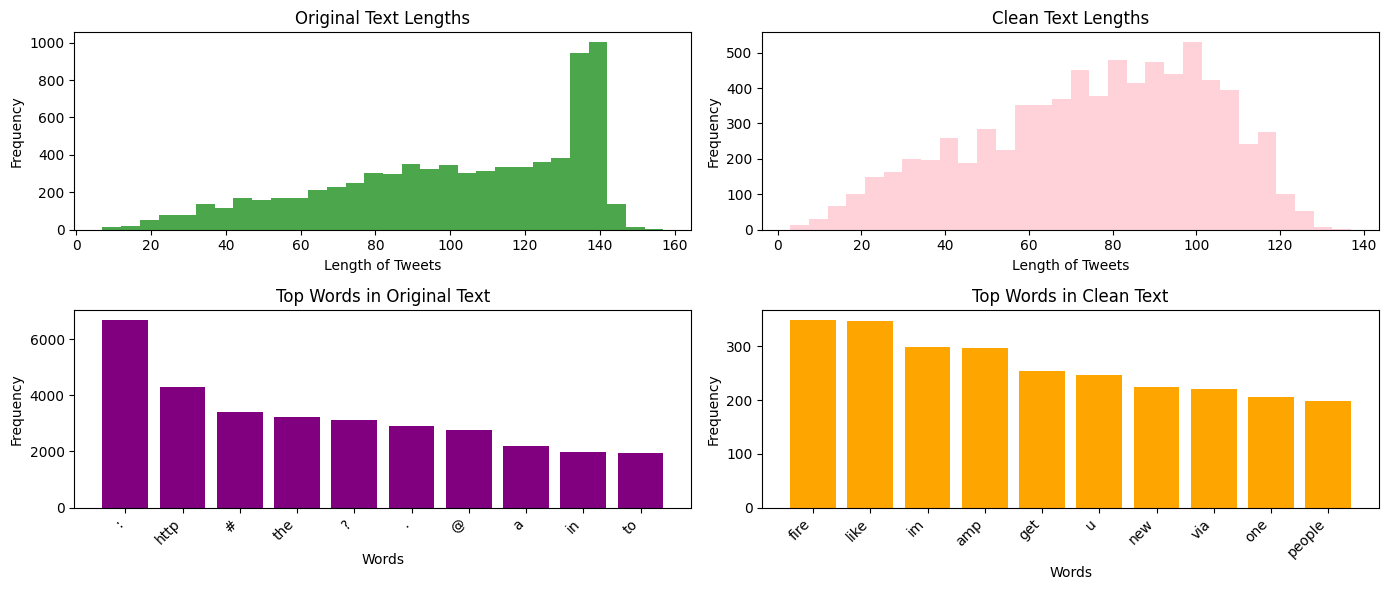

In [9]:
train['original_length'] = train['text'].apply(len)
train['clean_length'] = train['clean_text'].apply(len)

original_words = word_tokenize(' '.join(train['text']).lower())
original_counter = Counter(original_words)
most_common_original = original_counter.most_common(10)
original_words, original_counts = zip(*most_common_original)

clean_words = word_tokenize(' '.join(train['clean_text']).lower())
clean_counter = Counter(clean_words)
most_common_clean = clean_counter.most_common(10)
clean_words, clean_counts = zip(*most_common_clean)

plt.figure(figsize=(14, 6))
plt.subplot(2, 2, 1)

plt.hist(train['original_length'], bins=30, color='green', alpha=0.7)
plt.title('Original Text Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')

plt.subplot(2, 2, 2)
plt.hist(train['clean_length'], bins=30, color='pink', alpha=0.7)
plt.title('Clean Text Lengths')
plt.xlabel('Length of Tweets')
plt.ylabel('Frequency')

plt.subplot(2, 2, 3)
plt.bar(original_words, original_counts, color='purple')
plt.title('Top Words in Original Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.subplot(2, 2, 4)
plt.bar(clean_words, clean_counts, color='orange')
plt.title('Top Words in Clean Text')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

### Normalization and EDA Results:

Above you can see the resulting graphs of our data preprocessing, cleaning, and normalizaiton As you can see, the text length of the original data in contrast to the clean data is far more evenly distributed in frequency and length. There are hardly any outliers in the clean data in comparison to drastic and steep peaks in the original.

You may also see that through the utilization of NLP our most used words has drastically changed. Our cleaned data distribution of frequently used words looks incredible as it mostly pertains to disasters and people ensuring that we've filtered out most of what we saw in the original data which is symbols and super common words such as "the".

## Model Architecture:

After struggling to make Word2vec work, I ended up settling on using TF-IDF for my natural language processing. TF-IDF is fantastic for using on these tweets as it distinguishes relevance of words taking in considerations for values we already have in our data analysis. This also helped in making parameter tuning easier in the end.

Upon performing data analysis on our test and train data I decided to utilize the long short-term memory network. I felt this was appropriate as LSTM is able to handle long sequences, sequential data, and perform feature extraction and manipulation which we mentioned was our goal initially

After building this model I trained it on my data and observed the results which you will see in the next section.

In [10]:
vectorizer = TfidfVectorizer(max_features=1000)
X_train_tfidf = vectorizer.fit_transform(train['clean_text']).toarray()

X_test_tfidf = vectorizer.transform(test['clean_text']).toarray()

X_train_tfidf = np.expand_dims(X_train_tfidf, axis=1)
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)

In [11]:
model = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                210200    
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 210251 (821.29 KB)
Trainable params: 210251 (821.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
y_train = train['target'].values
history = model.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

Epoch 1/10
191/191 [==============================] - 4s 10ms/step - loss: 0.6851 - accuracy: 0.5783 - val_loss: 0.6721 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 1s 7ms/step - loss: 0.5555 - accuracy: 0.6962 - val_loss: 0.5224 - val_accuracy: 0.7715
Epoch 3/10
191/191 [==============================] - 2s 8ms/step - loss: 0.4337 - accuracy: 0.8059 - val_loss: 0.4836 - val_accuracy: 0.7794
Epoch 4/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3965 - accuracy: 0.8220 - val_loss: 0.4828 - val_accuracy: 0.7807
Epoch 5/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3803 - accuracy: 0.8282 - val_loss: 0.4894 - val_accuracy: 0.7610
Epoch 6/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3695 - accuracy: 0.8317 - val_loss: 0.4968 - val_accuracy: 0.7636
Epoch 7/10
191/191 [==============================] - 1s 7ms/step - loss: 0.3624 - accuracy: 0.8419 - val_loss: 0.5118 - val_accuracy: 0.7564
Epoch

## Results and Analysis

As you can see from our test and train results for accuracy and loss below, our model does pretty well. The model starts out with more loss and higher accuraccy but is able to acchieve a pretty high accuracy of almmost 85% by the last epoch. Below we'll see if we can improve this by hyperparameterizaton.

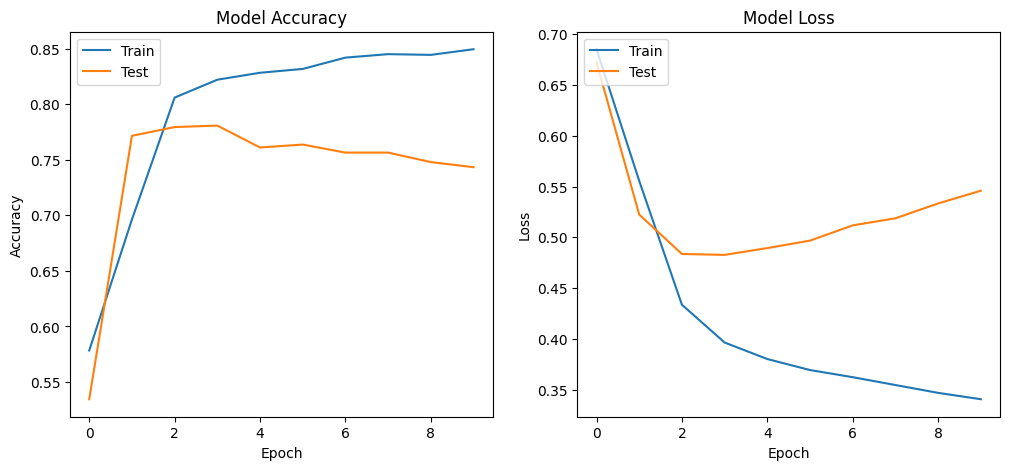

In [14]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

### Hyperparameterization & Fine Tuning


In [16]:
model2 = Sequential([
    LSTM(50,
         activation = "relu",
         recurrent_activation = "tanh",
         input_shape=(1, 1000)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model2.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model2.summary()

history2 = model2.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

model3 = Sequential([
    LSTM(50,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model3.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
model3.summary()

history3 = model3.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

model4 = Sequential([
    LSTM(30,
         activation = "tanh",
         recurrent_activation = "relu",
         input_shape=(1, 1000)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model4.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
model4.summary()

history4 = model4.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

#####################################################################################################################################################

model5 = Sequential([
    LSTM(50,
         activation = "sigmoid",
         recurrent_activation = "tanh",
         input_shape=(1, 1000)),
    Dropout(0.5),
    Dense(1, activation='relu')
])

model5.compile(loss='mean_squared_error', metrics=['accuracy'], optimizer='adam')
model5.summary()

history5 = model5.fit(X_train_tfidf, y_train, epochs=10, validation_split=0.2, batch_size=32)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 50)                210200    
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 210251 (821.29 KB)
Trainable params: 210251 (821.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
191/191 [==============================] - 9s 17ms/step - loss: 0.6873 - accuracy: 0.5782 - val_loss: 0.6836 - val_accuracy: 0.5345
Epoch 2/10
191/191 [==============================] - 1s 8ms/step - loss: 0.6012 - accuracy: 0.6435 - val_loss: 0.5716 - val_accuracy: 

### After Hyperparameterization:
While these are not all of the hyperparemeterizations conducted, you can see below that we were able to tune the parameters of our model to increace accuracy by almost 3%. This is substantial, and you can also see how changing other parameters worsened our model.

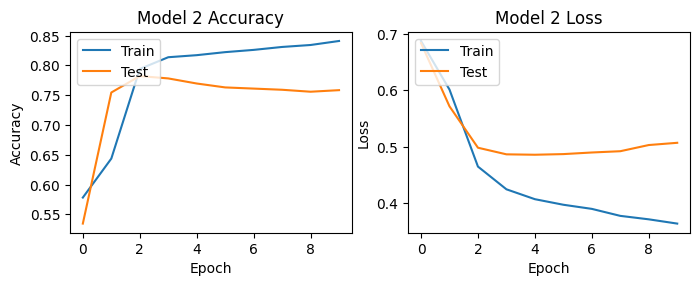

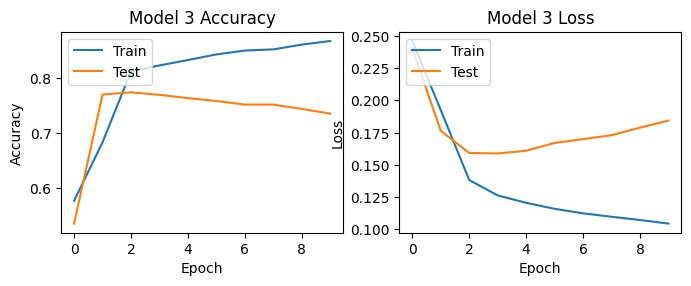

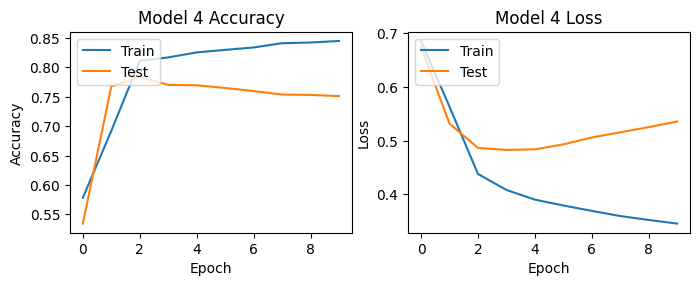

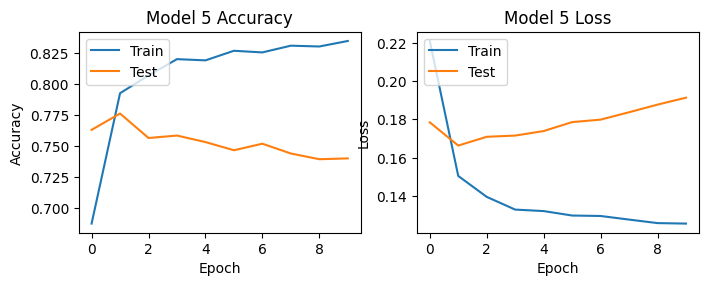

In [30]:
plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 1)
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model 2 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 2)
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Model 2 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 3)
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Model 3 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 4)
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Model 3 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 5)
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Model 4 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 6)
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Model 4 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.figure(figsize=(8, 12))
plt.subplot(4, 2, 7)
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Model 5 Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(4, 2, 8)
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Model 5 Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')


plt.show()

## Conclusion

After applying a long short-term memory neural network on data that we used natural language processing on I'd say we successfuly were able to accurately classify real and not real disasters based on the scope of this project.

A pitfall was definitely trying to figure out how to vectorize my data after I had processed it. I wish I could have tried multiple versions of this, but only had the chance to test different parameters within my overall model.

Overall I appreciated the tenserflow keras layout that shows you your accuracies along the way. This was super helpful in being able to visualize our results and practice data understanding.

### Download Submssion Result

In [194]:
X_test_tfidf = vectorizer.transform(test['clean_text']).toarray()
X_test_tfidf = np.expand_dims(X_test_tfidf, axis=1)

predictions = model.predict(X_test_tfidf)
predictions = (predictions > 0.5).astype(int)


submission = pd.DataFrame({
    'Id': test['id'],
    'Target': predictions.flatten()
})

submission.to_csv('submission.csv', index=False)


102/102 [==============================] - 1s 5ms/step


In [195]:
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## References

[LSTM](https://www.analyticsvidhya.com/blog/2022/05/disaster-tweet-classification-using-lstm-nlp/)

[TFIDF](https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a)

[LSTM TUTORIAL](https://www.youtube.com/watch?v=rmxogwIjOhE)

[LSTM Statquest](https://www.youtube.com/watch?v=YCzL96nL7j0)
